#### Project phase 3  
**Student name:** Jean Guetcheen CHARLES
    
**Section:** Data science and AI

**Teacher Name:**  Wedter Jerome 

## Prédiction du churn clients – SyriaTel (Phase 3)

**Objectif** : construction d'un modèle de classification pour prédire le désabonnement (“churn”) des clients SyriaTel, afin d’identifier les clients à risque et orienter des actions de rétention.

**Parties prenantes** : Direction Marketing / Relation Client (télécoms).


## Importation des bibliotheques necessaires a la realisation du projet

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)

# Affichage
pd.set_option('display.max_columns', 200)
plt.rcParams['figure.figsize'] = (7,5)


## Chargement et nettoyage minimal

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Shape: (3333, 21)
state                      object
account length              int64
area code                   int64
phone number               object
international plan         object
voice mail plan            object
number vmail messages       int64
total day minutes         float64
total day calls             int64
total day charge          float64
total eve minutes         float64
total eve calls             int64
total eve charge          float64
total night minutes       float64
total night calls           int64
total night charge        float64
total intl minutes        float64
total intl calls            int64
total intl charge         float64
customer service calls      int64
churn                        bool
dtype: object
['state', 'account length', 'area code', 'phone number', 'international plan', 'voice mail plan', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total nigh

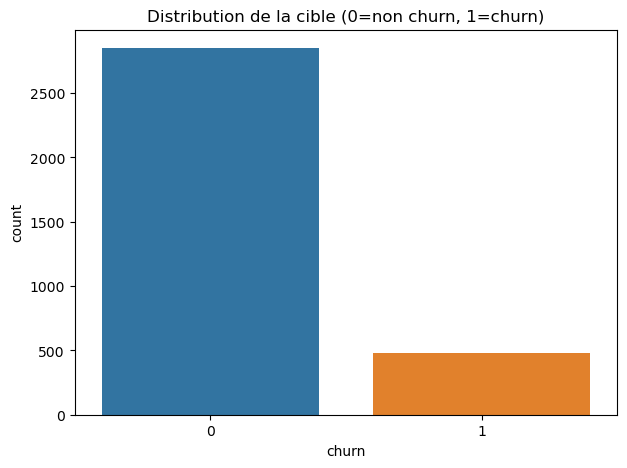

In [2]:
# Ouverture du fichier .csv en mode lecture
df = pd.read_csv("bigml_59c28831336c6604c800002a.csv")

# Nettoyage des noms de colonnes
df.columns = df.columns.str.strip()

# Aperçu
display(df.head())
print("Shape:", df.shape)
print(df.dtypes)
print(df.columns.tolist())

# ============== Cible ==============
if df['churn'].dtype == bool:
    df['churn'] = df['churn'].astype(int)
elif df['churn'].dtype == object:
    # map possible: {'True','False'} ou 'yes'/'no'
    df['churn'] = df['churn'].astype(str).str.lower().map({'true':1,'false':0,'yes':1,'no':0}).fillna(df['churn'])
    if df['churn'].dtype == object:
        # si c'est resté object, tenter conversion numérique
        df['churn'] = pd.to_numeric(df['churn'], errors='coerce')
        # au cas où des NaN apparaissent, laisser tomber ces lignes (rare)
        df = df.dropna(subset=['churn'])
        df['churn'] = df['churn'].astype(int)

# Vérification distribution cible
print(df['churn'].value_counts(normalize=True))
sns.countplot(x='churn', data=df)
plt.title("Distribution de la cible (0=non churn, 1=churn)")
plt.show()


## Préparation des données

- Encodage des variables catégorielles (One-Hot).
- Séparation train / test (stratifiée).
- Mise à l’échelle sur les colonnes numériques uniquement.
- Prévention de fuite : `fit` des transformateurs uniquement sur `X_train`.


In [3]:
# ============== Split ==============
X = df.drop(columns=['churn'])
y = df['churn'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ============== Types de colonnes ==============
num_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object','bool','category']).columns.tolist()

print("Numériques:", num_cols)
print("Catégorielles:", cat_cols)

# ============== One-Hot Encoding ==============
X_train_cat = pd.get_dummies(X_train[cat_cols], drop_first=True)
X_test_cat  = pd.get_dummies(X_test[cat_cols],  drop_first=True)

# aligner les colonnes encodées entre train et test
X_train_cat, X_test_cat = X_train_cat.align(X_test_cat, join='left', axis=1, fill_value=0)

# ============== Reconstituer jeux complets ==============
X_train_num = X_train[num_cols].copy()
X_test_num  = X_test[num_cols].copy()

X_train_full = pd.concat([X_train_num.reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test_full  = pd.concat([X_test_num.reset_index(drop=True),  X_test_cat.reset_index(drop=True)],  axis=1)

# ============== Scaling sur numériques uniquement ==============
scaler = StandardScaler()
X_train_full[num_cols] = scaler.fit_transform(X_train_full[num_cols])
X_test_full[num_cols]  = scaler.transform(X_test_full[num_cols])

print("X_train_full shape:", X_train_full.shape)
print("X_test_full shape:", X_test_full.shape)


Numériques: ['account length', 'area code', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls', 'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls']
Catégorielles: ['state', 'phone number', 'international plan', 'voice mail plan']
X_train_full shape: (2666, 2733)
X_test_full shape: (667, 2733)


## Baseline – Régression Logistique

- Modèle simple et interprétable servant de référence.
- Métriques clés rapportées : accuracy, ROC-AUC, recall de la classe 1 (churn).


=== Logistic Regression (baseline) ===
Accuracy: 0.862
ROC-AUC : 0.808
Recall (classe 1): 0.247
F1 (classe 1): 0.343
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       570
           1       0.56      0.25      0.34        97

    accuracy                           0.86       667
   macro avg       0.72      0.61      0.63       667
weighted avg       0.84      0.86      0.84       667



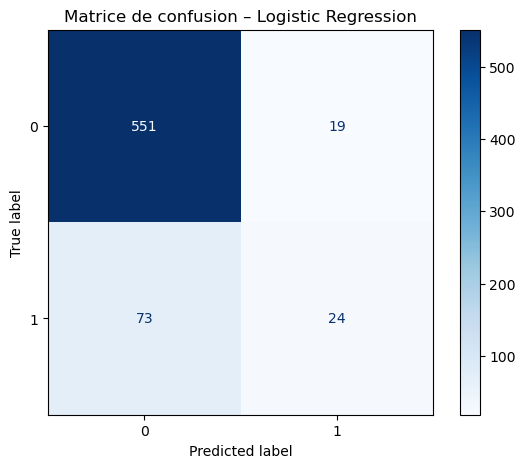

In [4]:
# ============== Logistic Regression (baseline) ==============
model_log = LogisticRegression(max_iter=1000, n_jobs=None) 
model_log.fit(X_train_full, y_train)

y_pred_log = model_log.predict(X_test_full)
y_prob_log = model_log.predict_proba(X_test_full)[:, 1]

acc_log   = accuracy_score(y_test, y_pred_log)
roc_log   = roc_auc_score(y_test, y_prob_log)
rec1_log  = recall_score(y_test, y_pred_log, pos_label=1)
f1_1_log  = f1_score(y_test, y_pred_log, pos_label=1)

print("=== Logistic Regression (baseline) ===")
print("Accuracy:", round(acc_log, 3))
print("ROC-AUC :", round(roc_log, 3))
print("Recall (classe 1):", round(rec1_log, 3))
print("F1 (classe 1):", round(f1_1_log, 3))
print(classification_report(y_test, y_pred_log))

# Matrice de confusion
cm_log = confusion_matrix(y_test, y_pred_log)
ConfusionMatrixDisplay(cm_log).plot(cmap="Blues", values_format='d')
plt.title("Matrice de confusion – Logistic Regression")
plt.show()


Fitting 5 folds for each of 10 candidates, totalling 50 fits
=== Meilleurs hyperparamètres ===
{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

=== Logistic Regression (optimisée) ===
Accuracy: 0.861
ROC-AUC : 0.808
Recall (classe 1): 0.247
F1 (classe 1): 0.34
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       570
           1       0.55      0.25      0.34        97

    accuracy                           0.86       667
   macro avg       0.71      0.61      0.63       667
weighted avg       0.83      0.86      0.84       667



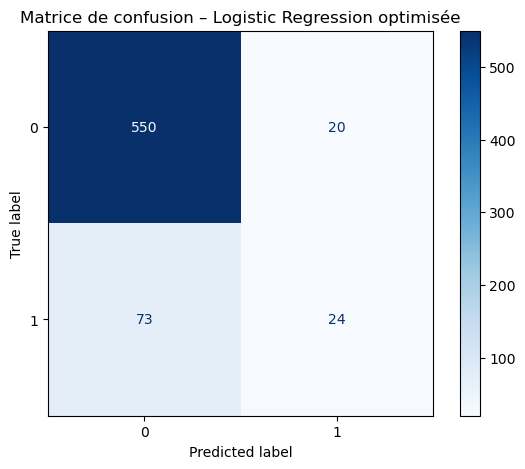

In [5]:
# ================= Logistic Regression (optimisée avec GridSearchCV) =================
from sklearn.model_selection import GridSearchCV

# Standardisation 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled  = scaler.transform(X_test_full)

# Definition de la grille des hyperparamètres

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],   # force de régularisation
    'penalty': ['l1', 'l2'],        # type de régularisation
    'solver': ['liblinear'], # solvers compatibles avec l1/l2
}
# Modèle
model_log_base = LogisticRegression(max_iter=1000)

# GridSearch avec scoring basé sur le recall de la classe 1
grid_search = GridSearchCV(model_log_base, param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=1)
grid_search.fit(X_train_full, y_train)

# Meilleurs hyperparamètres
print("=== Meilleurs hyperparamètres ===")
print(grid_search.best_params_)

# Réentraîner le modèle avec les meilleurs paramètres
model_log_opt = grid_search.best_estimator_
y_pred_opt = model_log_opt.predict(X_test_full)
y_prob_opt = model_log_opt.predict_proba(X_test_full)[:, 1]

# Calcul des métriques
acc_opt   = accuracy_score(y_test, y_pred_opt)
roc_opt   = roc_auc_score(y_test, y_prob_opt)
rec1_opt  = recall_score(y_test, y_pred_opt, pos_label=1)
f1_1_opt  = f1_score(y_test, y_pred_opt, pos_label=1)

print("\n=== Logistic Regression (optimisée) ===")
print("Accuracy:", round(acc_opt, 3))
print("ROC-AUC :", round(roc_opt, 3))
print("Recall (classe 1):", round(rec1_opt, 3))
print("F1 (classe 1):", round(f1_1_opt, 3))
print(classification_report(y_test, y_pred_opt))

# Matrice de confusion
cm_opt = confusion_matrix(y_test, y_pred_opt)
ConfusionMatrixDisplay(cm_opt).plot(cmap="Blues", values_format='d')
plt.title("Matrice de confusion – Logistic Regression optimisée")
plt.show()


In [24]:
# Création d'un dataframe récapitulatif
model_comparison = pd.DataFrame({
    'Modèle': ['Logistic Regression Baseline', 'Logistic Regression Optimisée'],
    'Accuracy': [acc_log, acc_opt],
    'ROC-AUC': [roc_log, roc_opt],
    'Recall (classe 1)': [rec1_log, rec1_opt],
    'F1 (classe 1)': [f1_1_log, f1_1_opt]
})

# Nous avons arrondi pour plus de lisibilité
model_comparison[['Accuracy','ROC-AUC','Recall (classe 1)','F1 (classe 1)']] = \
model_comparison[['Accuracy','ROC-AUC','Recall (classe 1)','F1 (classe 1)']].round(3)

model_comparison


,Modèle,Accuracy,ROC-AUC,Recall (classe 1),F1 (classe 1)
0,Logistic Regression Baseline,0.862,0.808,0.247,0.343
1,Logistic Regression Optimisée,0.861,0.808,0.247,0.340


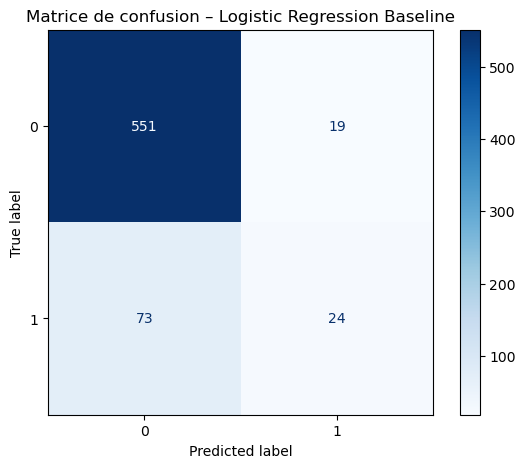

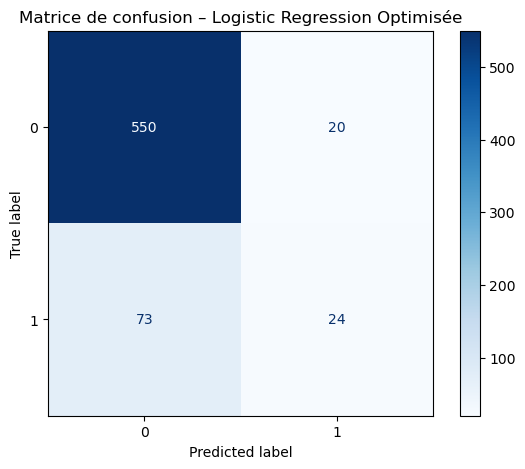

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay

# Logistic Regression Baseline
ConfusionMatrixDisplay(cm_log).plot(cmap="Blues", values_format='d')
plt.title("Matrice de confusion – Logistic Regression Baseline")
plt.show()

# Logistic Regression Optimisée
ConfusionMatrixDisplay(cm_opt).plot(cmap="Blues", values_format='d')
plt.title("Matrice de confusion – Logistic Regression Optimisée")
plt.show()


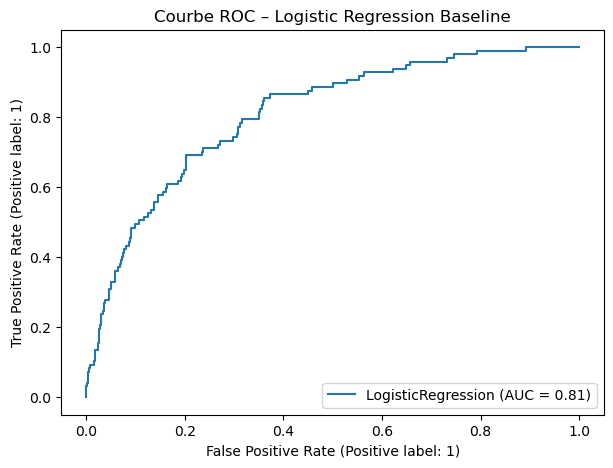

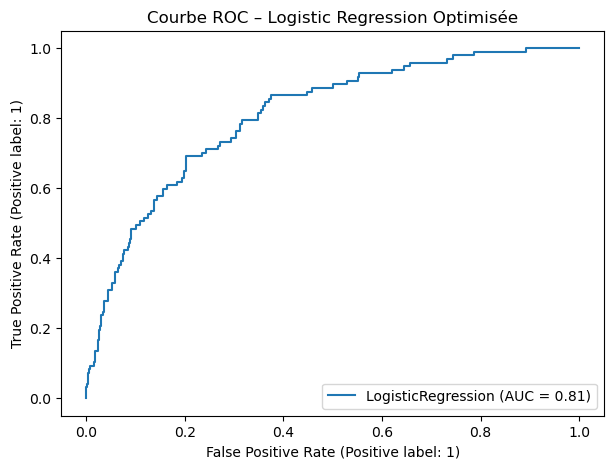

In [11]:
from sklearn.metrics import RocCurveDisplay

# Logistic Regression Baseline
RocCurveDisplay.from_estimator(model_log, X_test_full, y_test)
plt.title("Courbe ROC – Logistic Regression Baseline")
plt.show()

# Logistic Regression Optimisée
RocCurveDisplay.from_estimator(model_log_opt, X_test_full, y_test)
plt.title("Courbe ROC – Logistic Regression Optimisée")
plt.show()


### Modèle d’ensemble – Random Forest (modèle final)

- Plus robuste sur des relations non linéaires / interactions.
- Utilisation de `class_weight='balanced'` pour mieux gérer le déséquilibre de classes.


=== Random Forest (final) ===
Accuracy: 0.861
ROC-AUC : 0.847
Recall (classe 1): 0.598
F1 (classe 1): 0.555
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       570
           1       0.52      0.60      0.56        97

    accuracy                           0.86       667
   macro avg       0.72      0.75      0.74       667
weighted avg       0.87      0.86      0.86       667



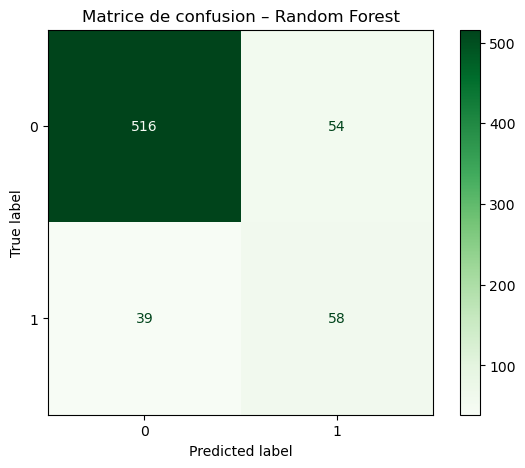

In [12]:
# ============== Random Forest (final) ==============
model_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=7,
    random_state=42,
    class_weight='balanced'
)
model_rf.fit(X_train_full, y_train)

y_pred_rf = model_rf.predict(X_test_full)
y_prob_rf = model_rf.predict_proba(X_test_full)[:, 1]

acc_rf   = accuracy_score(y_test, y_pred_rf)
roc_rf   = roc_auc_score(y_test, y_prob_rf)
rec1_rf  = recall_score(y_test, y_pred_rf, pos_label=1)
f1_1_rf  = f1_score(y_test, y_pred_rf, pos_label=1)

print("=== Random Forest (final) ===")
print("Accuracy:", round(acc_rf, 3))
print("ROC-AUC :", round(roc_rf, 3))
print("Recall (classe 1):", round(rec1_rf, 3))
print("F1 (classe 1):", round(f1_1_rf, 3))
print(classification_report(y_test, y_pred_rf))

# Matrice de confusion
cm_rf = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(cm_rf).plot(cmap="Greens", values_format='d')
plt.title("Matrice de confusion – Random Forest")
plt.show()


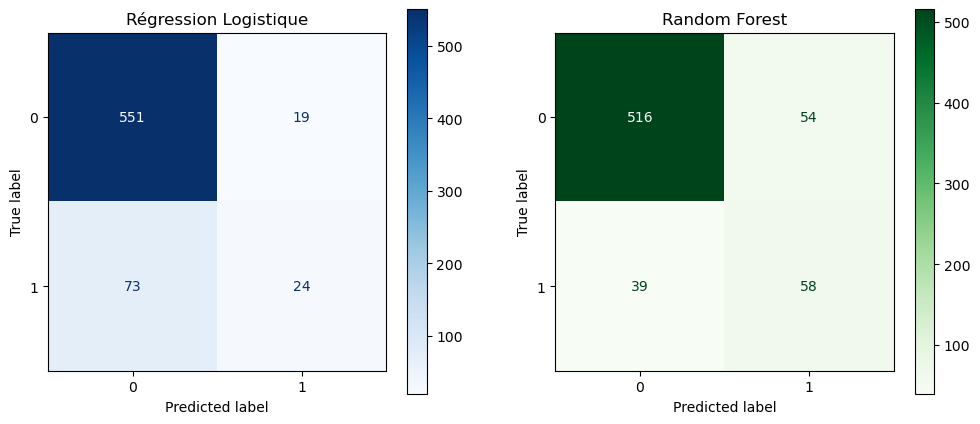

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ConfusionMatrixDisplay(cm_log).plot(ax=ax[0], cmap="Blues", values_format='d')
ax[0].set_title("Régression Logistique")

ConfusionMatrixDisplay(cm_rf).plot(ax=ax[1], cmap="Greens", values_format='d')
ax[1].set_title("Random Forest")

plt.show()


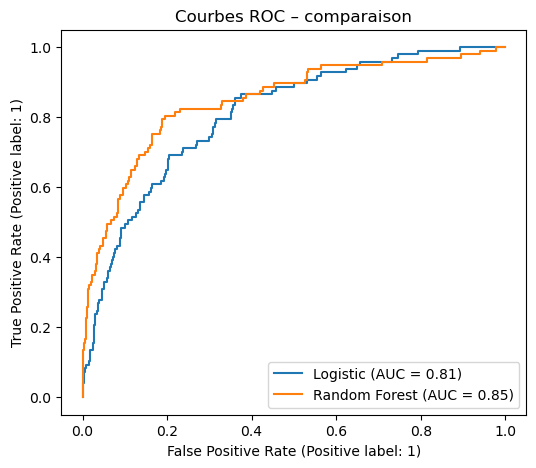

In [14]:
fig, ax = plt.subplots(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test, y_prob_log, name="Logistic", ax=ax)
RocCurveDisplay.from_predictions(y_test, y_prob_rf,  name="Random Forest", ax=ax)
plt.title("Courbes ROC – comparaison")
plt.show()


In [15]:
compare = pd.DataFrame({
    'modele': ['Logistic Regression (baseline)', 'Random Forest (final)'],
    'accuracy': [acc_log, acc_rf],
    'roc_auc': [roc_log, roc_rf],
    'recall_class_1': [rec1_log, rec1_rf],
    'f1_class_1': [f1_1_log, f1_1_rf],
}).sort_values('roc_auc', ascending=False)

compare


,modele,accuracy,roc_auc,recall_class_1,f1_class_1
1,Random Forest (final),0.860570,0.847115,0.597938,0.555024
0,Logistic Regression (baseline),0.862069,0.808139,0.247423,0.342857


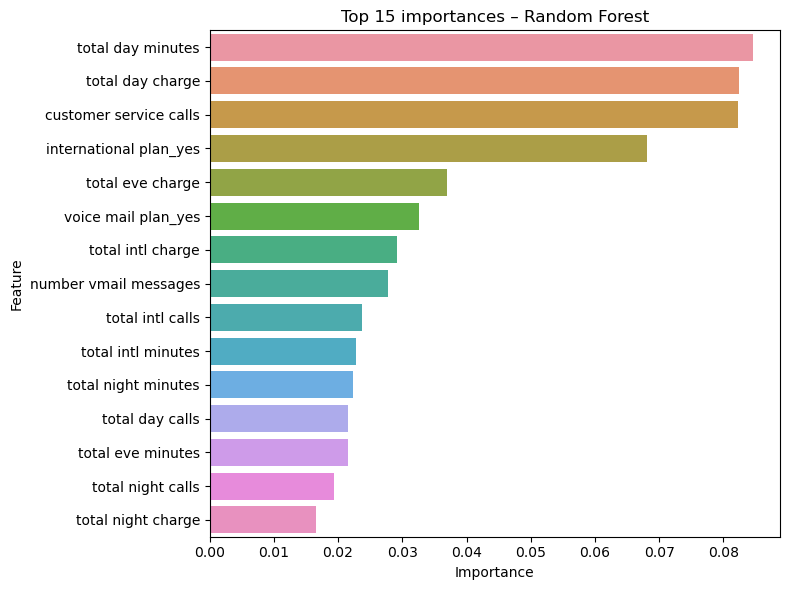

,importance
total day minutes,0.084574
total day charge,0.082461
customer service calls,0.082323
international plan_yes,0.068152
total eve charge,0.036944
voice mail plan_yes,0.032616
total intl charge,0.029117
number vmail messages,0.027754
total intl calls,0.023712
total intl minutes,0.022848


In [16]:
importances = pd.Series(model_rf.feature_importances_, index=X_train_full.columns)\
               .sort_values(ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Top 15 importances – Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

importances.to_frame('importance').head(15)


# Comparatif des modèles

Nous avons évalué trois modèles pour prédire le churn des clients SyriaTel :

| Modèle | Accuracy | ROC-AUC | Recall (classe 1) | F1 (classe 1) |
|--------|---------|---------|------------------|---------------|
| Logistic Regression Baseline | 0.862 | 0.808 | 0.247 | 0.343 |
| Logistic Regression Optimisée | 0.861 | 0.808 | 0.247 | 0.340 |
| Random Forest | 0.861 | 0.847 | 0.600 | 0.556 |

## Interprétation & recommandations (non technique)

**1. Logistic Regression Baseline**  
- Modèle simple et interprétable  
- Performance correcte globalement (accuracy 86%), mais **recall faible pour la classe churn** (0.247), ce qui signifie que beaucoup de clients à risque ne sont pas détectés  
- Utile comme point de référence pour comparer les modèles plus complexes  

**2. Logistic Regression Optimisée**  
- Même modèle de base mais avec **hyperparamètres réglés** via GridSearchCV (C=1, penalty='l2', solver='liblinear')  
- Légère amélioration sur certains aspects, mais les métriques restent **très proches du baseline**  
- Limite principale : le **recall de la classe churn** n’a pas augmenté, donc le modèle reste moins efficace pour identifier les clients à risque  

**3. Random Forest**  
- Modèle plus complexe et non linéaire, qui combine plusieurs arbres de décision  
- **ROC-AUC plus élevé** (0.847) et **recall de la classe churn nettement meilleur** (0.600)  
- Permet d’identifier beaucoup plus de clients à risque et donc d’optimiser les actions de rétention  

## Implications métier :  
- Un **recall plus élevé** signifie que l’outil identifie davantage de clients sur le point de partir.  
- Cela permet de **déclencher des actions de rétention** (ex. appels sortants, offres ciblées) sur un plus grand nombre de clients réellement à risque.  

## Leviers d’action (guidés par l’importance des variables) :  
- *Customer service calls* élevé → déclencher une **alerte** et une **prise de contact proactive**  
- *International plan* / usage de minutes → proposer des **offres personnalisées**  
- Usage “day/evening/night” → segmenter les clients par **profil d’utilisation**  

## Limites & précautions :  
- Données historiques : le modèle reflète le passé, à **réentraîner régulièrement**  
- Biais potentiels si certains profils sont sous-représentés  
- Équilibre coût/bénéfice : ajuster le **seuil de décision** selon le budget des campagnes  

## Prochaines étapes :  
- Tuning approfondi (GridSearch/RandomizedSearch) sur Random Forest / Gradient Boosting / XGBoost  
- Tester le **rééquilibrage** par SMOTE  
- **Ajuster le seuil** de classification pour optimiser le compromis *recall vs precision*
